# Training data

In [2]:
import pickle
import numpy as np
import random
from operator import add

In [3]:
f = open ('./char_embedding.pkl', 'rb')
dict_char = pickle.load(f)
f.close()

f = open ('./dataset/item_index_withEN.pkl', 'rb')
item_index = pickle.load(f)
f.close()

f = open ('./dataset/name_index_withEN.pkl', 'rb')
user_index = pickle.load(f)
f.close()

In [4]:
rating_mat = np.load('dataset/user_item_withEN_mat.npy')

In [5]:
print("dict_char", len(dict_char))
print("user_index", len(user_index))
print("item_index", len(item_index))
print("rating_mat", rating_mat.shape)

dict_char 21592
user_index 15251
item_index 32
rating_mat (15251, 32)


In [6]:
#dict_char['沈']
#user_list.remove('')
k, v = random.choice(list(dict_char.items()))
print(type(v))
#print(user_list)

<class 'numpy.ndarray'>


In [8]:
user_list = list(user_index.keys())
print(len(user_list))
user_mat = []
user_con_mat = []
user_emb = []
con_emb = []
count = 0

for user in user_list:
    temp = []
    for char in user:
        try:
            temp.append(dict_char[char])
        except:
            count += 1
            k, v = random.choice(list(dict_char.items()))
            temp.append(v)
    #print(len(temp))
    if len(temp) == 2:
        # k, v = random.choice(list(dict_char.items()))
        user_emb = np.mean([temp[0], temp[1]], axis=0)
        con_emb = np.concatenate((temp[0], temp[1], temp[1]))
    elif len(temp) == 3:
        user_emb = np.mean([temp[0], temp[1], temp[2]], axis=0)
        con_emb = np.concatenate((temp[0], temp[1], temp[2]))
    elif len(temp) == 4:
        user_emb = np.mean([temp[0], temp[1], temp[2], temp[-1]], axis=0)
        con_emb = np.concatenate((temp[0], temp[1], temp[2]))
    else:
        print("index", user_list.index(user))
        #rating_mat = np.delete(rating_mat, [user_list.index(user)], axis=0)
        user_list.remove(user)
        del user_index[user]
        print(len(temp))
    user_con_mat.append(con_emb)
    user_mat.append(user_emb)

user_mat = np.array(user_mat)
user_con_mat = np.array(user_con_mat)
print("missing char", count)
print("user_mat", user_mat.shape)
print("user_con_mat", user_con_mat.shape)
print("remain", len(user_list))
print("remain", rating_mat.shape)

15250
missing char 190
user_mat (15250, 256)
user_con_mat (15250, 768)
remain 15250
remain (15250, 32)


In [9]:
#item_shape = (256, 32)
#item_mat = np.random.rand(32, 256)
print(user_mat)

[[-0.25516173  0.02200902 -0.6367982  ...  0.27963406  0.06052778
  -0.2570803 ]
 [-0.00804286 -0.43483147 -0.4136071  ...  0.5910477   0.11055978
  -0.76872826]
 [-0.18077803 -0.28984937 -0.42697546 ...  0.38626578  0.0096873
  -0.5621365 ]
 ...
 [ 0.31248116 -0.27425033  0.06705994 ...  0.5632503   0.6493718
  -0.25115702]
 [-0.59236026  0.25725064  0.44351003 ...  0.8128228  -0.12497162
  -0.08346231]
 [-0.06863866  0.05283417  0.21988375 ...  0.6965713   0.10992792
  -0.58061045]]


In [10]:
num_user = 15250
num_item = 32

# Model

In [83]:
from keras import Model
import keras.backend as K
from keras.layers import Embedding,Reshape,Input,Dot, Dense, dot, Lambda
from keras.models import load_model
K.clear_session()

In [84]:
import matplotlib.pyplot as plt

In [85]:
# def create_model(num_user, num_item, k):
#     input_user = Input(shape=(256,),dtype="float32")
#     #model_uer = Embedding(num_user+1,k,input_length = 1)(input_uer)
#     model_user = Dense(k, activation='relu')(input_user)
#     model_user = Reshape((k,))(model_user)
    
#     input_item = Input(shape=(32,),dtype="float32")
#     model_item  = Embedding(num_item+1,k,input_length = 32)(input_item)
#     model_item = Dense(256, activation='relu')(model_item)
#     model_item = Reshape((256,))(model_item)
    
#     out = Dot(1)([model_user,model_item])
#     model = Model(inputs=[input_user,model_item], outputs=out)
#     model.compile(loss='mse', optimizer='Adam')
#     model.summary()
#     return model

In [86]:
def Recmand_model(num_user,num_item,k):
    input_uer = Input(shape=(256, ),dtype="float32")
    model_uer = Dense(128, activation='relu')(input_uer)
    model_uer = Dense(128, activation='relu')(model_uer)
    model_uer = Dense(k, activation='relu')(model_uer)
    
    
    input_item = Input(shape=(1,), dtype="float32")
    model_item  = Embedding(num_item, k, input_length = 1)(input_item)
    model_item = Reshape((k,))(model_item)
    
    out = Lambda(lambda x: K.sum(x[0]*x[1], axis=-1, keepdims=True))([model_uer, model_item])
    model = Model(inputs=[input_uer, input_item], outputs=out)
    model.compile(loss='mse', optimizer='Adam')
    model.summary()
    return model

In [87]:
model = Recmand_model(num_user, num_item, 64)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          16512       dense_1[0][0]                    
__________________________________________________________________________________________________
embedding_

In [88]:
# batch_size = 10
test_user = np.random.random((10, 256))
test_item = np.random.randint(0,32, (10))

In [89]:
print(test_user)

[[0.29901757 0.5823561  0.86731756 ... 0.61725474 0.82741774 0.49550487]
 [0.06286934 0.94492315 0.40991161 ... 0.13180082 0.59067381 0.82368266]
 [0.67093234 0.32414039 0.13268445 ... 0.29868517 0.8051694  0.44593921]
 ...
 [0.49542275 0.75667983 0.03181926 ... 0.38699856 0.78678761 0.67152014]
 [0.82811759 0.84200775 0.09937715 ... 0.30100663 0.51301124 0.37208237]
 [0.43832434 0.90023346 0.72115588 ... 0.43404931 0.38658265 0.16685667]]


In [90]:
print(test_item)

[15 20 21 20  4 27  9  4  4 21]


In [91]:
# test predict
#model.predict([np.random.random((10, 256)), np.random.randint(0,32, (10))])

In [92]:
#print(user_con_mat)
print(user_mat)

[[-0.25516173  0.02200902 -0.6367982  ...  0.27963406  0.06052778
  -0.2570803 ]
 [-0.00804286 -0.43483147 -0.4136071  ...  0.5910477   0.11055978
  -0.76872826]
 [-0.18077803 -0.28984937 -0.42697546 ...  0.38626578  0.0096873
  -0.5621365 ]
 ...
 [ 0.31248116 -0.27425033  0.06705994 ...  0.5632503   0.6493718
  -0.25115702]
 [-0.59236026  0.25725064  0.44351003 ...  0.8128228  -0.12497162
  -0.08346231]
 [-0.06863866  0.05283417  0.21988375 ...  0.6965713   0.10992792
  -0.58061045]]


In [93]:
user_index = 0
item_index = 0
train_x = []
train_user = []
train_item = []

for u in rating_mat:
    for i in u:
        if i == 1:
            # train_x.append([user_mat[user_index], [item_index]])
            #u_list = user_con_mat[user_index].tolist()
            #train_user.append(u_list)
            train_user.append(user_mat[user_index].tolist())
            #print(user_mat[user_index].tolist())
            train_item.append(item_index)
        item_index += 1
    user_index += 1
    item_index = 0
train_x = [np.array(train_user), np.array(train_item)]

In [94]:
#train_x = np.array(train_x)
print(train_x)
#print(train_x)
train_y = [1] * 39911
train = [1] * 10
#print(train_y)

[array([[-0.25516173,  0.02200902, -0.6367982 , ...,  0.27963406,
         0.06052778, -0.25708029],
       [-0.25516173,  0.02200902, -0.6367982 , ...,  0.27963406,
         0.06052778, -0.25708029],
       [-0.25516173,  0.02200902, -0.6367982 , ...,  0.27963406,
         0.06052778, -0.25708029],
       ...,
       [ 0.31248116, -0.27425033,  0.06705994, ...,  0.5632503 ,
         0.6493718 , -0.25115702],
       [-0.59236026,  0.25725064,  0.44351003, ...,  0.81282282,
        -0.12497162, -0.08346231],
       [-0.06863866,  0.05283417,  0.21988375, ...,  0.69657129,
         0.10992792, -0.58061045]]), array([6, 7, 8, ..., 0, 0, 0])]


In [95]:
history = model.fit(train_x, train_y, batch_size = 64, epochs =300, verbose=1, validation_split=0.2, shuffle=True)

Train on 31928 samples, validate on 7983 samples
Epoch 1/300
31928/31928 [==============================] - 1s 41us/step - loss: 0.0252 - val_loss: 0.2503
Epoch 2/300
31928/31928 [==============================] - 1s 33us/step - loss: 7.3889e-04 - val_loss: 0.2481
Epoch 3/300
31928/31928 [==============================] - 1s 33us/step - loss: 5.0267e-04 - val_loss: 0.2452
Epoch 4/300
31928/31928 [==============================] - 1s 32us/step - loss: 4.0113e-04 - val_loss: 0.2429
Epoch 5/300
31928/31928 [==============================] - 1s 33us/step - loss: 3.5860e-04 - val_loss: 0.2417
Epoch 6/300
31928/31928 [==============================] - 1s 35us/step - loss: 3.8398e-04 - val_loss: 0.2401
Epoch 7/300
31928/31928 [==============================] - 1s 32us/step - loss: 3.0279e-04 - val_loss: 0.2388
Epoch 8/300
31928/31928 [==============================] - 1s 33us/step - loss: 2.5464e-04 - val_loss: 0.2398
Epoch 9/300
31928/31928 [==============================] - 1s 33us/step - l

31928/31928 [==============================] - 1s 33us/step - loss: 1.2588e-05 - val_loss: 0.2196
Epoch 75/300
31928/31928 [==============================] - 1s 31us/step - loss: 5.6887e-06 - val_loss: 0.2196
Epoch 76/300
31928/31928 [==============================] - 1s 32us/step - loss: 2.2998e-06 - val_loss: 0.2196
Epoch 77/300
31928/31928 [==============================] - 1s 32us/step - loss: 4.7803e-06 - val_loss: 0.2197
Epoch 78/300
31928/31928 [==============================] - 1s 32us/step - loss: 1.2938e-05 - val_loss: 0.2195
Epoch 79/300
31928/31928 [==============================] - 1s 31us/step - loss: 9.4335e-08 - val_loss: 0.2195
Epoch 80/300
31928/31928 [==============================] - 1s 32us/step - loss: 5.9909e-06 - val_loss: 0.2194
Epoch 81/300
31928/31928 [==============================] - 1s 31us/step - loss: 5.7125e-06 - val_loss: 0.2194
Epoch 82/300
31928/31928 [==============================] - 1s 32us/step - loss: 4.3839e-06 - val_loss: 0.2195
Epoch 83/300
3

31928/31928 [==============================] - 1s 32us/step - loss: 2.1037e-07 - val_loss: 0.2177
Epoch 148/300
31928/31928 [==============================] - 1s 31us/step - loss: 3.9258e-06 - val_loss: 0.2177
Epoch 149/300
31928/31928 [==============================] - 1s 33us/step - loss: 4.0254e-06 - val_loss: 0.2175
Epoch 150/300
31928/31928 [==============================] - 1s 32us/step - loss: 1.6978e-10 - val_loss: 0.2175
Epoch 151/300
31928/31928 [==============================] - 1s 32us/step - loss: 7.1628e-06 - val_loss: 0.2175
Epoch 152/300
31928/31928 [==============================] - 1s 32us/step - loss: 3.3301e-07 - val_loss: 0.2175
Epoch 153/300
31928/31928 [==============================] - 1s 32us/step - loss: 6.9399e-07 - val_loss: 0.2175
Epoch 154/300
31928/31928 [==============================] - 1s 31us/step - loss: 7.2272e-06 - val_loss: 0.2175
Epoch 155/300
31928/31928 [==============================] - 1s 32us/step - loss: 1.4928e-06 - val_loss: 0.2175
Epoch 

31928/31928 [==============================] - 1s 32us/step - loss: 2.4216e-06 - val_loss: 0.2159
Epoch 221/300
31928/31928 [==============================] - 1s 32us/step - loss: 3.4303e-06 - val_loss: 0.2159
Epoch 222/300
31928/31928 [==============================] - 1s 33us/step - loss: 2.4463e-07 - val_loss: 0.2159
Epoch 223/300
31928/31928 [==============================] - 1s 32us/step - loss: 2.7677e-06 - val_loss: 0.2159
Epoch 224/300
31928/31928 [==============================] - 1s 32us/step - loss: 4.0452e-07 - val_loss: 0.2159
Epoch 225/300
31928/31928 [==============================] - 1s 33us/step - loss: 2.8647e-06 - val_loss: 0.2159
Epoch 226/300
31928/31928 [==============================] - 1s 33us/step - loss: 7.0136e-07 - val_loss: 0.2159
Epoch 227/300
31928/31928 [==============================] - 1s 32us/step - loss: 3.6325e-06 - val_loss: 0.2159
Epoch 228/300
31928/31928 [==============================] - 1s 32us/step - loss: 6.9410e-07 - val_loss: 0.2159
Epoch 

31928/31928 [==============================] - 1s 32us/step - loss: 1.4608e-06 - val_loss: 0.2159
Epoch 294/300
31928/31928 [==============================] - 1s 32us/step - loss: 5.9159e-07 - val_loss: 0.2159
Epoch 295/300
31928/31928 [==============================] - 1s 32us/step - loss: 2.3199e-06 - val_loss: 0.2159
Epoch 296/300
31928/31928 [==============================] - 1s 32us/step - loss: 6.0206e-07 - val_loss: 0.2159
Epoch 297/300
31928/31928 [==============================] - 1s 32us/step - loss: 1.2886e-06 - val_loss: 0.2159
Epoch 298/300
31928/31928 [==============================] - 1s 33us/step - loss: 1.2965e-06 - val_loss: 0.2159
Epoch 299/300
31928/31928 [==============================] - 1s 31us/step - loss: 4.0938e-07 - val_loss: 0.2159
Epoch 300/300
31928/31928 [==============================] - 1s 31us/step - loss: 1.7777e-06 - val_loss: 0.2159


In [96]:
model.save('my_model.h5')

In [101]:
model_300 = load_model('./my_model_300.h5')
model_500 = load_model('./my_model_500.h5')
model_con_300 = load_model('./my_model_con_300.h5')

In [99]:
#embeddings = model.layers[2].get_weights()[0]
#embeddings = model.layers[4].get_weights()[0]

In [58]:
# embeddings.shape
# embed = embeddings.T
# print(embed.shape)

(32, 64)

## Graph

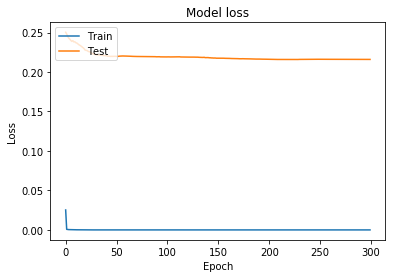

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predict 

In [59]:
sc_name_dict = {'CGU':"長庚大學", 'CMU':"中國醫藥大學", 'CYCU':"中原大學", 'FCU':"逢甲大學", 'KMU':"高雄醫學大學", 
                'NCCU':"政治大學", 'NCHU':"中興大學", 'NCKU':"成功大學", 'NCTU':"交通大學", 'NCUE':"彰化師範大學", 
                'NDHU':"東華大學", 'NKNU':"高雄師範大學", 'NPTU':"屏東大學", 'NSYSU':"中山大學", 'NTCU':"臺中教育大學", 
                'NTHU':"清華大學", 'NTNU':"臺灣師範大學", 'NTU':"臺灣大學", 'NTUE':"臺北教育大學", 'NUTN':"臺南大學",
                'SCU':"東吳大學", 'THU':"東海大學", 'TKU':"淡江大學", 'TNUA':"臺北藝術大學", 'UTAIPEI':"臺北市立大學",
                'YM':"陽明大學"}

In [60]:
names = ["馬崇堯", "周東誼", "鬍子元", "龍澳天", "黃智賢"]
#name = "周東誼"

In [104]:
def getCharEmbed(name):
    temp = []
    for char in name:
        try:
            temp.append(dict_char[char])
        except:
            k, v = random.choice(list(dict_char.items()))
            temp.append(v)
            
    if len(temp) == 2:
        # k, v = random.choice(list(dict_char.items()))
        user_emb = np.mean([temp[0], temp[1]], axis=0)
        con_emb = np.concatenate((temp[0], temp[1], temp[1]))
    elif len(temp) == 3:
        user_emb = np.mean([temp[0], temp[1], temp[2]], axis=0)
        con_emb = np.concatenate((temp[0], temp[1], temp[2]))
    elif len(temp) == 4:
        user_emb = np.mean([temp[0], temp[1], temp[2], temp[-1]], axis=0)
        con_emb = np.concatenate((temp[0], temp[1], temp[2]))
    else:
        for i in range(3):
            k, v = random.choice(list(dict_char.items()))
            temp.append(v)
        user_emb = v
        con_emb = np.concatenate((temp[0], temp[1], temp[2]))
    
    #return user_emb
    return con_emb

In [62]:
us = []
for name in names:
    u = getCharEmbed(name)
    us.append(u)
sc = np.array(range(32))

In [63]:
print(us[0].shape)

(256,)


In [64]:
#model.predict([np.random.random((10, 256)), np.random.randint(0,32, (10))])
#np.random.random((10, 256))

In [65]:
f = open ('./dataset/item_index_withEN.pkl', 'rb')
item_index_dict = pickle.load(f)
f.close()

item_index_dict 

{'董事': 0,
 '董事長': 1,
 '獨立董事': 2,
 '副董事長': 3,
 '常務董事': 4,
 '執行業務股東': 5,
 'CGU': 6,
 'CMU': 7,
 'CYCU': 8,
 'FCU': 9,
 'KMU': 10,
 'NCCU': 11,
 'NCHU': 12,
 'NCKU': 13,
 'NCTU': 14,
 'NCUE': 15,
 'NDHU': 16,
 'NKNU': 17,
 'NPTU': 18,
 'NSYSU': 19,
 'NTCU': 20,
 'NTHU': 21,
 'NTNU': 22,
 'NTU': 23,
 'NTUE': 24,
 'NUTN': 25,
 'SCU': 26,
 'THU': 27,
 'TKU': 28,
 'TNUA': 29,
 'UTAIPEI': 30,
 'YM': 31}

In [66]:
def getSchool(item_index_dict, score_list):
    broad_list = []
    for i in range(len(score_list)):
        if score_list[i] == 1:
            for k, v in item_index_dict.items():
                if v == i:
                    broad_list.append(k)
    return broad_list

In [67]:
for i in range(len(us)):
    print(names[i])
    u = us[i]
    score_list = []
    for i in range(32):
        output = model.predict([[u], [i]])
        if output[0][0] > 0.85:
            score_list.append(1)
        else:
            score_list.append(0)
    print(score_list)
    output_list = getSchool(item_index_dict, score_list)

馬崇堯
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
周東誼
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
鬍子元
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
龍澳天
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
黃智賢
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [68]:
#print(score_list)

In [69]:
output_list = getSchool(item_index_dict, score_list)

In [70]:
print(output_list)
print(len(output_list))

['CGU', 'CMU', 'CYCU', 'FCU', 'KMU', 'NCCU', 'NCHU', 'NCKU', 'NCTU', 'NCUE', 'NDHU', 'NKNU', 'NPTU', 'NSYSU', 'NTCU', 'NTHU', 'NTNU', 'NTU', 'NTUE', 'NUTN', 'SCU', 'THU', 'TKU', 'TNUA', 'UTAIPEI', 'YM']
26


In [182]:
def predictSchool(name):
    count = 0
    max_score = 0
    max_sc_index = 0
    print(name)
    u = getCharEmbed(name)
    score_list = []
    ori_score_dict = {}
    for i in range(32):
        output = model_con_300.predict([[u], [i]])
        #output = model.predict([[u], [i]])
        ori_score_dict[output[0][0]] = i
        if output[0][0] > max_score:
            max_score = output[0][0]
            max_sc_index = i
        if output[0][0] > 0.82:
            score_list.append(1)
            count += 1
        else:
            score_list.append(0)
    print("你有極高機率會上的學校或職位有 :", count, "個")
    output_list = getSchool(item_index_dict, score_list)
    print("你有極高機率會上的學校或職位有 :", end=" ")
    for out in output_list:
        print(sc_name_dict[out], end=" ")
    print("\n")
    ori_score_list = list(ori_score_dict.keys())
    ori_score_list.sort(reverse=True)
    
    print("你會上的機率前五高學校或職位有 :")
    # print(ori_score_dict)
    # print(list(ori_score_dict.keys()))
    for ori in ori_score_list[:5]:
        print(list(sc_name_dict.values())[ori_score_dict[ori]-6], end=", ")
    print("\n")
    if count > 0:
        print("\n機率最大的是:", list(sc_name_dict.values())[max_sc_index-6])
        #print(max_sc_index)
    print("\n")
    max_sc_index = 0
    

In [183]:
for name in names:
    predictSchool(name)

馬崇堯
你有極高機率會上的學校或職位有 : 26 個
你有極高機率會上的學校或職位有 : 長庚大學 中國醫藥大學 中原大學 逢甲大學 高雄醫學大學 政治大學 中興大學 成功大學 交通大學 彰化師範大學 東華大學 高雄師範大學 屏東大學 中山大學 臺中教育大學 清華大學 臺灣師範大學 臺灣大學 臺北教育大學 臺南大學 東吳大學 東海大學 淡江大學 臺北藝術大學 臺北市立大學 陽明大學 

你會上的機率前五高學校或職位有 :
臺南大學, 逢甲大學, 臺中教育大學, 臺灣大學, 臺北教育大學, 


機率最大的是: 臺南大學


周東誼
你有極高機率會上的學校或職位有 : 0 個
你有極高機率會上的學校或職位有 : 

你會上的機率前五高學校或職位有 :
高雄師範大學, 清華大學, 臺北藝術大學, 逢甲大學, 中山大學, 



鬍子元
你有極高機率會上的學校或職位有 : 0 個
你有極高機率會上的學校或職位有 : 

你會上的機率前五高學校或職位有 :
臺中教育大學, 中山大學, 長庚大學, 臺北市立大學, 彰化師範大學, 



龍澳天
你有極高機率會上的學校或職位有 : 26 個
你有極高機率會上的學校或職位有 : 長庚大學 中國醫藥大學 中原大學 逢甲大學 高雄醫學大學 政治大學 中興大學 成功大學 交通大學 彰化師範大學 東華大學 高雄師範大學 屏東大學 中山大學 臺中教育大學 清華大學 臺灣師範大學 臺灣大學 臺北教育大學 臺南大學 東吳大學 東海大學 淡江大學 臺北藝術大學 臺北市立大學 陽明大學 

你會上的機率前五高學校或職位有 :
逢甲大學, 臺南大學, 政治大學, 長庚大學, 臺灣大學, 


機率最大的是: 逢甲大學


黃智賢
你有極高機率會上的學校或職位有 : 21 個
你有極高機率會上的學校或職位有 : 長庚大學 中國醫藥大學 逢甲大學 高雄醫學大學 政治大學 交通大學 彰化師範大學 東華大學 屏東大學 中山大學 臺中教育大學 清華大學 臺灣師範大學 臺灣大學 臺北教育大學 臺南大學 東海大學 淡江大學 臺北藝術大學 臺北市立大學 陽明大學 

你會上的機率前五高學校或職位有 :
中山大學, 逢甲大學, 臺灣大學, 臺中教育大學, 臺南大學, 


機率最大的是: 中山大學




In [184]:
predictSchool("韓國瑜")

韓國瑜
你有極高機率會上的學校或職位有 : 23 個
你有極高機率會上的學校或職位有 : 長庚大學 中國醫藥大學 逢甲大學 高雄醫學大學 政治大學 中興大學 交通大學 東華大學 高雄師範大學 屏東大學 中山大學 臺中教育大學 清華大學 臺灣師範大學 臺灣大學 臺北教育大學 臺南大學 東吳大學 東海大學 淡江大學 臺北藝術大學 臺北市立大學 陽明大學 

你會上的機率前五高學校或職位有 :
臺南大學, 東海大學, 屏東大學, 政治大學, 臺灣大學, 


機率最大的是: 臺南大學




In [185]:
predictSchool("黃崇明")

黃崇明
你有極高機率會上的學校或職位有 : 15 個
你有極高機率會上的學校或職位有 : 長庚大學 逢甲大學 政治大學 交通大學 東華大學 屏東大學 中山大學 臺中教育大學 臺灣師範大學 臺灣大學 臺北教育大學 臺南大學 東海大學 臺北藝術大學 臺北市立大學 

你會上的機率前五高學校或職位有 :
臺南大學, 東海大學, 臺灣大學, 臺中教育大學, 逢甲大學, 


機率最大的是: 臺南大學




In [186]:
predictSchool("王麒詳")

王麒詳
你有極高機率會上的學校或職位有 : 26 個
你有極高機率會上的學校或職位有 : 長庚大學 中國醫藥大學 中原大學 逢甲大學 高雄醫學大學 政治大學 中興大學 成功大學 交通大學 彰化師範大學 東華大學 高雄師範大學 屏東大學 中山大學 臺中教育大學 清華大學 臺灣師範大學 臺灣大學 臺北教育大學 臺南大學 東吳大學 東海大學 淡江大學 臺北藝術大學 臺北市立大學 陽明大學 

你會上的機率前五高學校或職位有 :
中山大學, 臺南大學, 臺灣大學, 東華大學, 逢甲大學, 


機率最大的是: 中山大學




In [187]:
predictSchool("趙偉廷")

趙偉廷
你有極高機率會上的學校或職位有 : 0 個
你有極高機率會上的學校或職位有 : 

你會上的機率前五高學校或職位有 :
臺灣大學, 清華大學, 淡江大學, 東華大學, 長庚大學, 





In [188]:
predictSchool("黃仁暐")

黃仁暐
你有極高機率會上的學校或職位有 : 19 個
你有極高機率會上的學校或職位有 : 長庚大學 中國醫藥大學 逢甲大學 政治大學 成功大學 彰化師範大學 東華大學 屏東大學 中山大學 臺中教育大學 清華大學 臺灣大學 臺北教育大學 臺南大學 東海大學 淡江大學 臺北藝術大學 臺北市立大學 陽明大學 

你會上的機率前五高學校或職位有 :
清華大學, 臺中教育大學, 政治大學, 長庚大學, 臺灣大學, 


機率最大的是: 清華大學




In [189]:
predictSchool("吳昭儀")

吳昭儀
你有極高機率會上的學校或職位有 : 5 個
你有極高機率會上的學校或職位有 : 東華大學 中山大學 清華大學 臺灣大學 臺南大學 

你會上的機率前五高學校或職位有 :
中山大學, 臺灣大學, 清華大學, 東華大學, 臺南大學, 


機率最大的是: 中山大學




In [190]:
predictSchool("林芊吟")

林芊吟
你有極高機率會上的學校或職位有 : 0 個
你有極高機率會上的學校或職位有 : 

你會上的機率前五高學校或職位有 :
長庚大學, 清華大學, 臺灣大學, 東吳大學, 東華大學, 



